# Demonstration of GriddedData averager 
**Context**
 - March 2016, internship Sylvie Su 

**Task**
 - compute mean mld in boxes : 1° x 1° x 1 month

**Method**
 - [x] define a tool for computing area weighted means in 1°x1° boxes over 1 month 
 - [x] compute the spatial mean of mld in boxes
 - [x] extend averaging to time dimension
 - [x] produce nice plots 
 


## Modules

In [1]:
### general purpose
import iris
import numpy as np
import numpy.ma as ma
iris.FUTURE.netcdf_promote=True
import iris.analysis.cartography
import GriddedData
### palettre
import matplotlib.cm as mplcm
import colormaps as cmaps
import matplotlib.cm as cm
cm.register_cmap(name='viridis', cmap=cmaps.viridis)
#import seaborn as sns
seq_cmap = cmaps.viridis # future default matplotlib
div_cmap = mplcm.seismic
### quick plot
import cartopy.crs as ccrs
%matplotlib inline
import matplotlib.pyplot as plt
import iris.quickplot as qplt

## Dataset

In [2]:
#!ls /Users/lesommer/data/NATL60/NATL60-MJM155-S/1d/2008/*BUOYANCYFLX.nc
filein = "/Users/lesommer/data/NATL60/NATL60-MJM155-S/1d/2008/NATL60-MJM155_y2008m03.1d_BUOYANCYFLX.nc"
datacube = iris.load(filein)
mxlcube, = datacube.extract('Mixed Layer Depth 0.01 ref.10m')
flxcube, = datacube.extract('buoyancy flux')
grdcube, = datacube.extract('Horizontal gradient of buoyancy.')
mxlcube.aux_coords[0].rename('true_time')
print(mxlcube)


Mixed Layer Depth 0.01 ref.10m / (m) (time: 31; -- : 3454; -- : 5422)
     Dimension coordinates:
          time                            x        -          -
     Auxiliary coordinates:
          true_time                       x        -          -
          latitude                        -        x          x
          longitude                       -        x          x
     Attributes:
          CASE: MJM155
          CONFIG: NATL60
          NCO: 4.4.6
          history: Fri Oct  9 09:25:52 2015: ncrcat NATL60-MJM155_y2008m03d01.1d_BUOYANCYFLX.nc...
          interval_operation: 40s
          interval_write: 1d
          nco_openmp_thread_number: 1
          online_operation: average
          output_frequency: 1d
          start_date: 20040101


/Users/lesommer/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/Iris-1.10.0_DEV-py2.7.egg/iris/fileformats/cf.py:362: UserWarning: Missing CF-netCDF boundary variable u'time_centered_bounds', referenced by netCDF variable u'time_centered'
  warnings.warn(message % (name, nc_var_name))
/Users/lesommer/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/Iris-1.10.0_DEV-py2.7.egg/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1326: UserWarning: Ignoring netCDF variable u'vohgradb' invalid units u's^{-2}'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))


## Preliminary analysis

### Daily averaged mld

/Users/lesommer/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


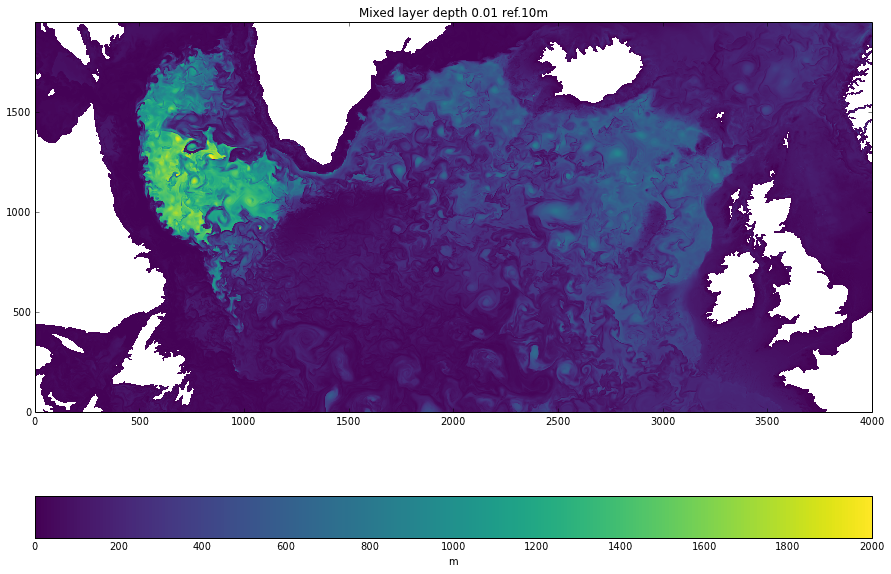

In [3]:
plt.figure(figsize=(15,10))
#p = qplt.contourf(mxlcube[20,1500:,1000:5000],100,cmap=seq_cmap);
cs = qplt.pcolormesh(mxlcube[20,1500:,1000:5000],cmap=seq_cmap,vmin=0,vmax=2000);
plt.autoscale(tight=True)
#p = qplt.contourf(mxlcube[20,1500:,1400:2500],100,cmap=cmap,projection=proj);

### Compute and plot monthly mean mixed layer depth

see : 
 - http://scitools.org.uk/iris/docs/latest/userguide/cube_maths.html
 - http://scitools.org.uk/iris/docs/latest/userguide/cube_statistics.html


In [4]:
print(mxlcube.summary(True))
mxl_timemean = mxlcube.collapsed('time', iris.analysis.MEAN)

Mixed Layer Depth 0.01 ref.10m / (m) (time: 31; -- : 3454; -- : 5422)


/Users/lesommer/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/Iris-1.10.0_DEV-py2.7.egg/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'true_time'.
  warnings.warn(msg.format(self.name()))


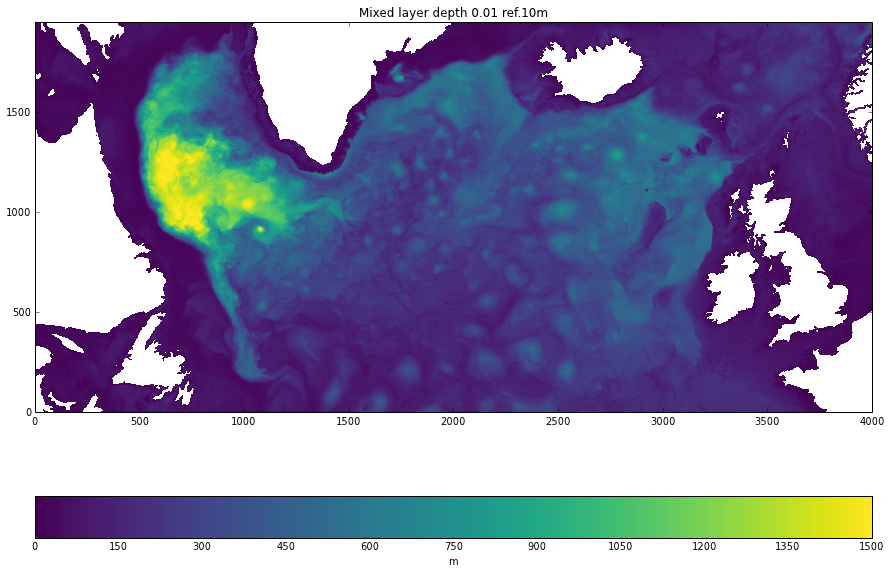

In [5]:
plt.figure(figsize=(15,10))
qplt.pcolormesh(mxl_timemean[1500:,1000:5000],cmap=seq_cmap,vmin=0,vmax=1500);
plt.autoscale(tight=True)

## Defines and use the regridder/averager

In [6]:
import GriddedData
mgrd = GriddedData.grid2D(navlat=mxlcube.aux_coords[1].points, navlon=mxlcube.aux_coords[2].points)
weigths = mgrd.t_surf

In [7]:
crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
tmld = crs(mxl_timemean.data)

<matplotlib.colorbar.Colorbar instance at 0x10d9ded40>

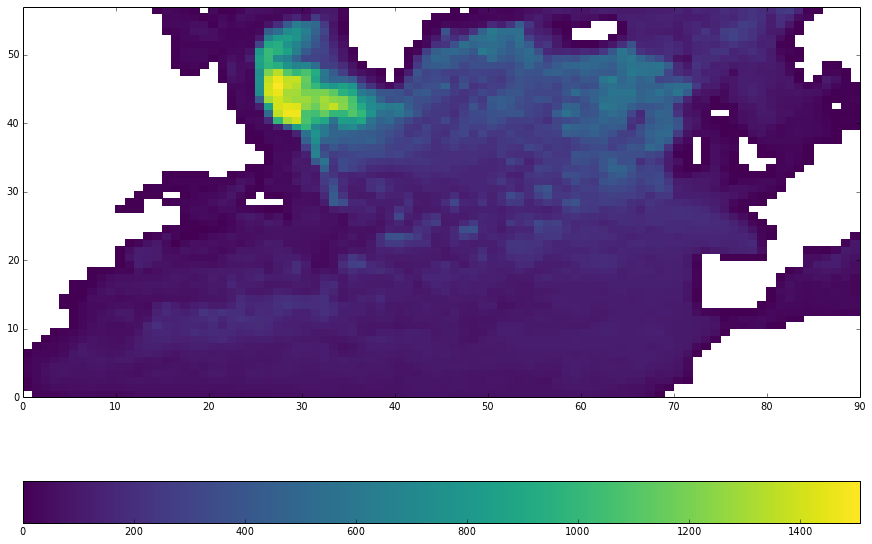

In [8]:
plt.figure(figsize=(15,10))
plt.pcolormesh(tmld,cmap=seq_cmap,vmin=0);
plt.autoscale(tight=True)
plt.colorbar(orientation='horizontal')

## Plots with cartopy

In [9]:
## plot
def nice_plot(lons,lats,data,cmap=seq_cmap,vmin=None,vmax=None):
    plt.figure(figsize=(15,10))
    proj = ccrs.PlateCarree()
    ax = plt.axes(projection=proj)
    cs = plt.pcolormesh(lons, lats, data,transform=proj,cmap=cmap,vmin=vmin,vmax=vmax)
    ax.coastlines(resolution="10m")
    ax.gridlines(draw_labels=True)
    cb = plt.colorbar(cs, extend='both', fraction=0.042, pad=0.04, orientation="horizontal") 

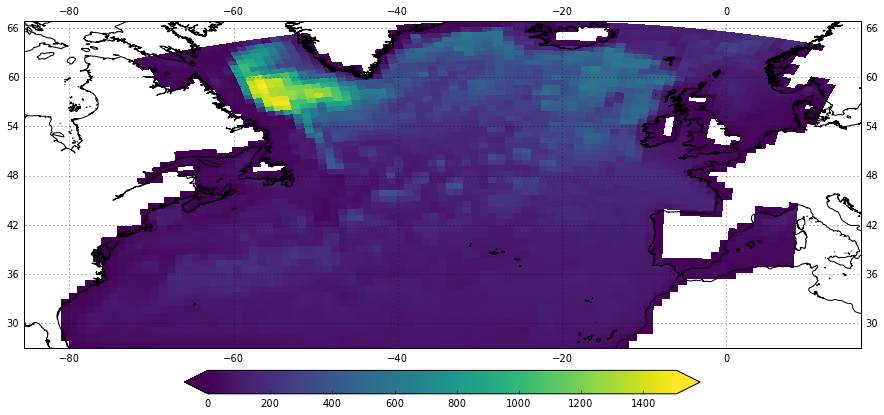

In [10]:
plt.figure(figsize=(15,10))
crslons = crs(mgrd.navlon)
crslats = crs(mgrd.navlat)
nice_plot(crslons,crslats,tmld)


## More nice plots

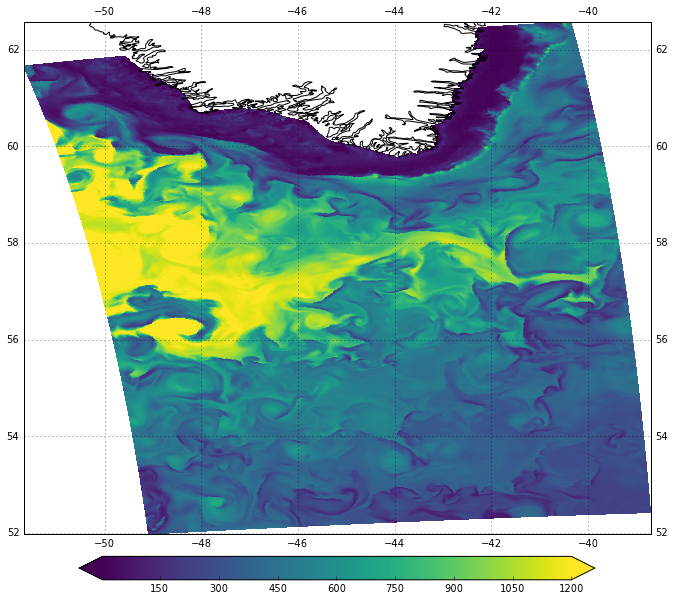

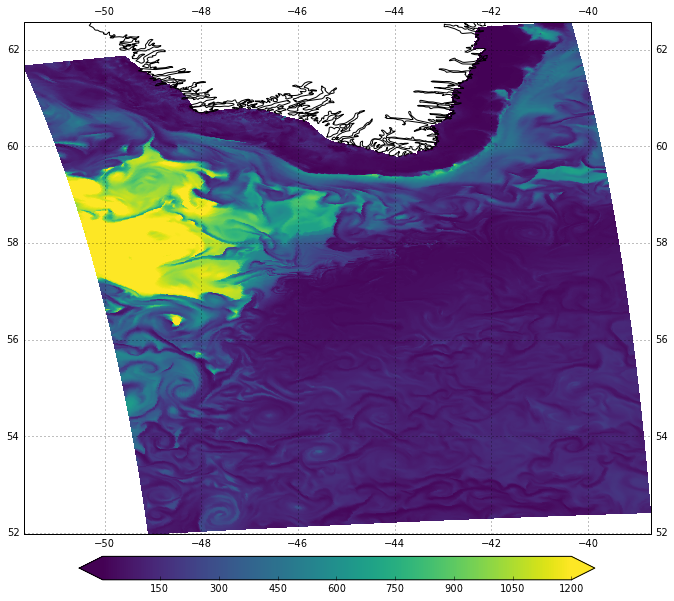

In [11]:
nice_plot(mgrd.navlon[2000:3000,2000:2600],mgrd.navlat[2000:3000,2000:2600],mxlcube[10].data[2000:3000,2000:2600],vmax=1200)
nice_plot(mgrd.navlon[2000:3000,2000:2600],mgrd.navlat[2000:3000,2000:2600],mxlcube[20].data[2000:3000,2000:2600],vmax=1200)
